Import potrebnih knjižnic za analizo podatkov:

In [59]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest

Prebiranje datotek s podakti, tukaj se ignorira vrstice, ki pokvarijo strukturo podatkov oziroma v originalni datoteki niso del podatkov temvec prazna vrstica ipd. 
V programski kodi so seveda zamaknjene za -1.

Izberemo tudi samo stolpce z izbranimi točkami:  
A - datumi  
B - povprecje  
C:IW - izbrane tocke  


od IW naprej so pa stolpci prazni in nekje v koncu dokumenta spet nekatere vrednosti, ki niso pomembne

Stolpec z datumi se spremeni v datume.

preberemo se za pretok, po stoplcih:  
A - datum  
B - pretok  
C - prazen  
D - temp. vode  
E - mot. vode  

se preimenujem pretok da bo lazje obdelovati

zdrzuimo oba dataframa s concat (axis = 1 pomeni da po stolpcih)


In [64]:
file_path = 'podatki/Rizana_Zaledje_INCA_dnev_2020_2021_N1.xlsx'
df_padavine = pd.read_excel(file_path, sheet_name='Izbrane', skiprows=[0, 1, 3, 4], usecols="A,C:IW")

df_padavine["datum"] = pd.to_datetime(df_padavine["datum"], format="%m/%d/%y")
df_padavine = df_padavine.set_index('datum')

file_path1 = 'podatki/Pretok_2020_2021_N1.xlsx'
df_pretok = pd.read_excel(file_path1, sheet_name='meritve', usecols="A, B")
df_pretok.rename(columns={"pretok (m3/s)": "pretok"}, inplace=True)

df_pretok["datum"] = pd.to_datetime(df_pretok["datum"], format="%d.%m.%Y")
df_pretok = df_pretok.set_index('datum')

df = pd.concat([df_pretok, df_padavine], axis=1)


### Normalne vrednosti in % odstopanja
- pogledati je treba katere so normalne vrednosti in kakšen procent predstavlja znatno odstopanje

Velikost: (731, 257)
Toliko vrstic vsebuje Nan: 0
Povprečni pretok: 2.757
Mediana pretok: 0.909
Najbolj pogost pretok: 0.193


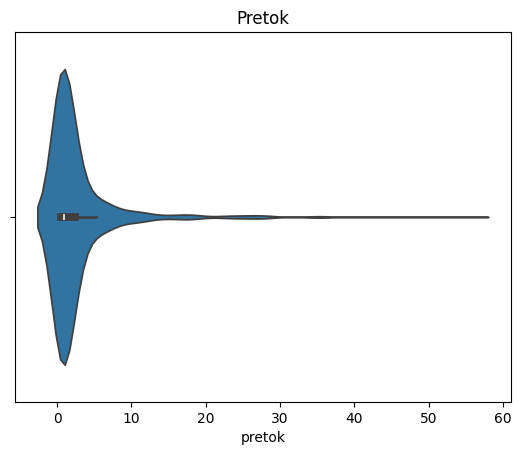

In [67]:
print(f"Velikost: {df.shape}")
#print(f"Stolpci: {df.columns.tolist()}")
"""
x = 5
print(df_pretok.head(x))
print(df_padavine.head(x))
print(df.sample(x))
"""
print(f"Toliko vrstic vsebuje Nan: {df.isna().any(axis=1).sum()}")

#zaokroženo na 3 mesta kot podatki
avgPretok = df['pretok'].mean().round(3) 
modPretok = df["pretok"].mode().iloc[0] 
#mode vrne vecje stevilo zato treba z iloc preveriti prvega ne glede na index
medPretok = df["pretok"].median().round(3)

print(f"Povprečni pretok: {avgPretok}")
print(f"Mediana pretok: {medPretok}")
print(f"Najbolj pogost pretok: {modPretok}")

sns.violinplot(x=df['pretok']) #za data distribution
plt.title("Pretok")
plt.show()

### Isolation forest anomaly detection


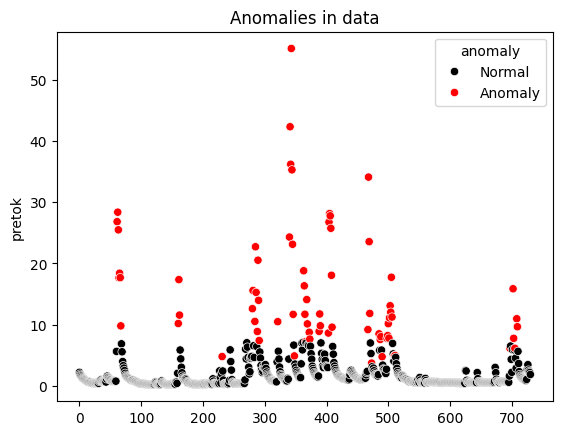

,pretok,68,69,95,96,97,98,122,123,124,...,567,570,571,572,573,574,575,596,601,anomaly
datum,,,,,,,,,,,,,,,,,,,,,
2020-04-09,0.374000,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,Normal
2021-05-26,4.925926,2.70,2.41,3.11,3.25,2.32,3.54,0.80,3.31,2.78,...,0.83,0.90,1.90,1.07,0.42,0.61,1.10,0.39,0.27,Anomaly
2020-04-14,0.339000,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,Normal
2020-07-14,0.247995,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,Normal
2020-06-01,0.262769,0.00,0.01,0.26,0.01,0.01,0.01,0.00,0.00,0.26,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,Normal
2021-05-14,8.187093,22.52,17.60,14.46,12.60,9.54,9.85,10.54,10.75,7.31,...,4.48,2.68,3.87,4.02,3.58,5.28,4.28,4.72,4.28,Anomaly
2020-08-19,4.761000,0.30,0.37,0.32,0.37,0.39,0.60,0.36,0.36,0.76,...,27.90,20.52,20.93,22.66,16.97,17.83,16.62,31.24,27.43,Anomaly
2020-08-20,2.398000,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,Normal
2020-08-08,0.347435,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,Normal


In [77]:
model = IsolationForest(n_estimators=100, max_samples='auto', contamination=0.1, max_features=1.0, bootstrap=False)
model.fit(df[['pretok']])
df['anomaly'] = model.predict(df[['pretok']])
df['anomaly'] = df['anomaly'].apply(lambda x: 'Anomaly' if x == -1 else 'Normal')

sns.scatterplot(x=range(len(df)), y='pretok', hue='anomaly', data=df, palette=['black', 'red'])
plt.title('Anomalies in data')
plt.show()

df.sample(10)
